In [1]:
%matplotlib inline

# 7 - Graph Distances

In this short tutorial, we will demonstrate how to use measure the distance between two graphs, based on the supplied methods.

- - -


### Load and prepare data 

In [2]:
import numpy as np
np.set_printoptions(threshold=np.nan)

In [3]:
labels = np.load('data/autism_labels.npy')
data = np.load('data/autism_fmri_thres_conn_mtx.npy')

In [4]:
labels = np.array(labels).astype(np.int32)

In [5]:
con_indices = np.where(labels == 0)[0]
aut_indices = np.where(labels == 1)[0]

In [6]:
con_indices = con_indices[0:10]
aut_indices = aut_indices[0:10]

In [7]:
ordered_data = np.vstack([data[con_indices, :, :],
                          data[aut_indices, :, :],
                         ])

ordered_data = np.abs(ordered_data)

In [8]:
num_subjects, num_rois, num_rois = np.shape(ordered_data)

In [9]:
print("""
            Subjects: {0}
Coonnectivity Matrix: {1}x{2}
""".format(num_subjects, num_rois, num_rois))


            Subjects: 20
Coonnectivity Matrix: 264x264



### Estimate the distances

In [10]:
from dyfunconn.graphs import graph_diffusion_distance, im_distance, spectral_euclidean_distance, spectral_k_distance

In [11]:
methods = {
    'gdd': graph_diffusion_distance,
    'imd': im_distance,
    'spectral': spectral_euclidean_distance,
    'k_spectral': spectral_k_distance
}

In [12]:
results = dict()

In [13]:
for name, func in methods.items():
    print('- Running method {0}...'.format(name), end=' ')
    
    distances = np.zeros((num_subjects, num_subjects))
    
    for x in range(num_subjects):
        for y in range(num_subjects):            
            mtx1 = ordered_data[x, :, :]
            mtx2 = ordered_data[y, :, :]
            
            # Workdaround until `spectral_k_distance`
            # gets a default value in its implementation.
            if name == 'k_spectral':
                method_distance = func(mtx1, mtx2, k=5)
            else:
                method_distance = func(mtx1, mtx2)
            
            if name == 'gdd':
                method_distance = method_distance[0]
            
            distances[x, y] = method_distance
    
    results[name] = distances
    
    print('Done.')

- Running method gdd... Done.
- Running method imd... 

/opt/py36/lib/python3.6/site-packages/scipy/integrate/quadpack.py:450: ComplexWarning: Casting complex values to real discards the imaginary part
  return _quadpack._qagie(func,bound,infbounds,args,full_output,epsabs,epsrel,limit)


Done.
- Running method spectral... Done.
- Running method k_spectral... Done.


### Plot 

Plot the distance matrices

In [14]:
import matplotlib.pyplot as plt

In [15]:
plot_labels = np.hstack([10 * ['CON'], 10 * ['AUT']])

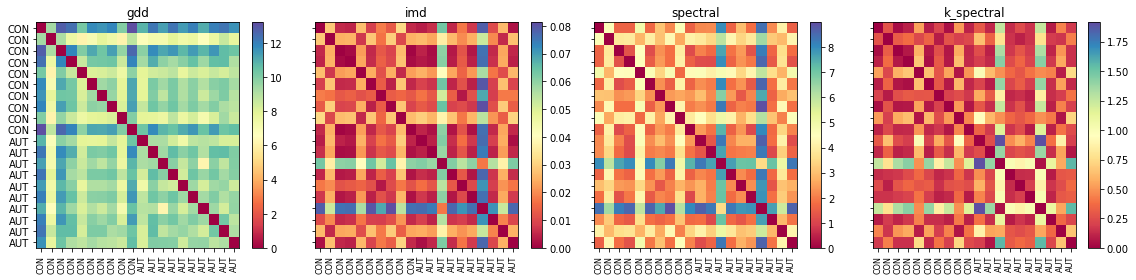

In [16]:
f, axes = plt.subplots(ncols=4, figsize=(16, 4), sharex=True, sharey=True)

for i, (name, mtx) in enumerate(results.items()):
    im = axes[i].imshow(mtx, cmap=plt.cm.Spectral)
    f.colorbar(im, ax=axes[i], )
    axes[i].set_title(name)
    axes[i].set_aspect('auto')
    axes[i].set_xticks(range(20))
    axes[i].set_xticklabels(plot_labels, fontsize=8, rotation=90)

plt.yticks(range(20), plot_labels, fontsize=8)
plt.tight_layout(h_pad=1)
plt.show()

Project the Graph Diffusion Distance matrix to two dimensions, using MDS

In [17]:
from sklearn.manifold import MDS

In [18]:
mds = MDS(n_components=2, dissimilarity='precomputed', random_state=0)
xy = mds.fit_transform(results['spectral'])

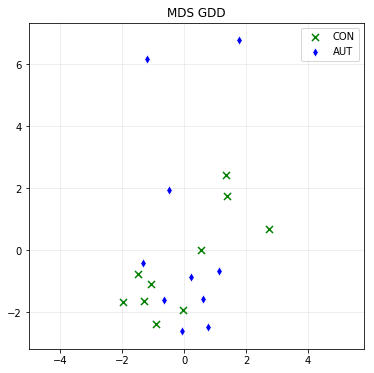

In [19]:
plot_labels = np.vstack([np.ones((10, 1)), np.ones((10, 1)) * 2]).squeeze()

plt.figure(figsize=(6, 6))
s1 = plt.scatter(xy[0:10, 0], xy[0:10, 1], marker='x', c='g', s=50, edgecolors='w', zorder=1000, label='CON')
s2 = plt.scatter(xy[10:, 0], xy[10:, 1], marker='d', c='b', s=50, edgecolors='w', zorder=1000, label='AUT')
plt.axis('equal')
plt.grid(alpha=0.25)
plt.legend()
plt.title('MDS GDD')
plt.show()